# Brain Tumor Classification using PSO-Optimized CNN

This notebook loads the optimal hyperparameters found by Particle Swarm Optimization (PSO) and trains a Convolutional Neural Network (CNN) for classifying brain tumor MRI images into four categories:
1. Glioma tumor
2. Meningioma tumor
3. No tumor
4. Pituitary tumor

We'll use PyTorch to build, train, and evaluate our model with the optimized hyperparameters.

## 1. Import Libraries

In [1]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms

# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

## 2. Check for GPU Availability

In [2]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


## 3. Load PSO Optimized Parameters

In [3]:
# Load the best parameters found by PSO
best_params = np.load('best_pso_params.npy')
print("Loaded PSO optimized parameters:")
print(f"Learning rate: {best_params[0]:.6f}")
print(f"Weight decay: {best_params[1]:.6f}")
print(f"Dropout1: {best_params[2]:.2f}")
print(f"Dropout2: {best_params[3]:.2f}")
print(f"Dropout3: {best_params[4]:.2f}")
print(f"Dropout FC: {best_params[5]:.2f}")
print(f"Filters1: {int(best_params[6])}")
print(f"Filters2: {int(best_params[7])}")
print(f"Filters3: {int(best_params[8])}")
print(f"Batch size: {int(best_params[9])}")

Loaded PSO optimized parameters:
Learning rate: 0.008208
Weight decay: 0.000000
Dropout1: 0.25
Dropout2: 0.18
Dropout3: 0.35
Dropout FC: 0.56
Filters1: 58
Filters2: 40
Filters3: 145
Batch size: 16


## 4. Define Configuration Parameters

In [4]:
# Define paths
train_dir = 'Dataset/Training/'
test_dir = 'Dataset/Testing/'

# Image dimensions
IMG_HEIGHT = 150
IMG_WIDTH = 150

# Extract parameters from PSO results
LEARNING_RATE = best_params[0]
WEIGHT_DECAY = best_params[1]
DROPOUT1 = best_params[2]
DROPOUT2 = best_params[3]
DROPOUT3 = best_params[4]
DROPOUT_FC = best_params[5]
FILTERS1 = int(best_params[6])
FILTERS2 = int(best_params[7])
FILTERS3 = int(best_params[8])
BATCH_SIZE = int(best_params[9])

# Training parameters
NUM_EPOCHS = 50
PATIENCE = 10  # For early stopping

## 5. Define the CNN Model Architecture

In [5]:
class BrainTumorCNN(nn.Module):
    def __init__(self, filters1=32, filters2=64, filters3=128, dropout1=0.25, dropout2=0.25, dropout3=0.25, dropout_fc=0.5):
        super(BrainTumorCNN, self).__init__()
        
        # First Convolutional Block
        self.conv1_1 = nn.Conv2d(3, filters1, kernel_size=3, padding=1)
        self.bn1_1 = nn.BatchNorm2d(filters1)
        self.conv1_2 = nn.Conv2d(filters1, filters1, kernel_size=3, padding=1)
        self.bn1_2 = nn.BatchNorm2d(filters1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(dropout1)
        
        # Second Convolutional Block
        self.conv2_1 = nn.Conv2d(filters1, filters2, kernel_size=3, padding=1)
        self.bn2_1 = nn.BatchNorm2d(filters2)
        self.conv2_2 = nn.Conv2d(filters2, filters2, kernel_size=3, padding=1)
        self.bn2_2 = nn.BatchNorm2d(filters2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(dropout2)
        
        # Third Convolutional Block
        self.conv3_1 = nn.Conv2d(filters2, filters3, kernel_size=3, padding=1)
        self.bn3_1 = nn.BatchNorm2d(filters3)
        self.conv3_2 = nn.Conv2d(filters3, filters3, kernel_size=3, padding=1)
        self.bn3_2 = nn.BatchNorm2d(filters3)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout3 = nn.Dropout(dropout3)
        
        # Calculate the size of the flattened features
        self.feature_size = (IMG_HEIGHT // 8) * (IMG_WIDTH // 8) * filters3
        
        # Fully connected layers
        self.fc1 = nn.Linear(self.feature_size, 512)
        self.bn_fc1 = nn.BatchNorm1d(512)
        self.dropout_fc1 = nn.Dropout(dropout_fc)
        self.fc2 = nn.Linear(512, 4)  # 4 classes
    
    def forward(self, x):
        # First block
        x = self.conv1_1(x)
        x = self.bn1_1(x)
        x = F.relu(x)
        x = self.conv1_2(x)
        x = self.bn1_2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Second block
        x = self.conv2_1(x)
        x = self.bn2_1(x)
        x = F.relu(x)
        x = self.conv2_2(x)
        x = self.bn2_2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Third block
        x = self.conv3_1(x)
        x = self.bn3_1(x)
        x = F.relu(x)
        x = self.conv3_2(x)
        x = self.bn3_2(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.bn_fc1(x)
        x = F.relu(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)
        
        return x

## 6. Data Preparation

In [6]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation/testing
test_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Split train dataset into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Training set size: 2296
Validation set size: 574
Test set size: 394


## 7. Training and Evaluation Functions

In [7]:
def train_epoch(model, dataloader, criterion, optimizer, phase):
    '''Train or validate for one epoch.'''
    if phase == 'train':
        model.train()
    else:
        model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        if optimizer:
            optimizer.zero_grad()
        
        # Forward pass
        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

## 8. Train Model with PSO Optimized Parameters

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, patience=PATIENCE):
    '''Train and evaluate the model with early stopping.'''
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    patience_counter = 0
    
    # For tracking training progress
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, 'train')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        
        # Validate
        with torch.no_grad():
            val_loss, val_acc = train_epoch(model, val_loader, criterion, None, 'val')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        # Update scheduler
        scheduler.step(val_loss)
        
        # Save history
        train_loss_history.append(train_loss)
        val_loss_history.append(val_loss)
        train_acc_history.append(train_acc.item())
        val_acc_history.append(val_acc.item())
        
        # Check if we have a new best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        print()
    
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')
    
    # Load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, train_loss_history, val_loss_history, train_acc_history, val_acc_history

# Create model with the PSO optimized parameters
model = BrainTumorCNN(
    filters1=FILTERS1,
    filters2=FILTERS2,
    filters3=FILTERS3,
    dropout1=DROPOUT1,
    dropout2=DROPOUT2,
    dropout3=DROPOUT3,
    dropout_fc=DROPOUT_FC
).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Train the model
model, train_loss_history, val_loss_history, train_acc_history, val_acc_history = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler
)

c:\Users\Amrzo\.conda\envs\bird\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50
----------
Train Loss: 1.2737 Acc: 0.5405
Val Loss: 1.2155 Acc: 0.5697

Epoch 2/50
----------
Train Loss: 1.1028 Acc: 0.6102
Val Loss: 0.8294 Acc: 0.6620

Epoch 3/50
----------
Train Loss: 0.9255 Acc: 0.6629
Val Loss: 1.0641 Acc: 0.6324

Epoch 4/50
----------
Train Loss: 0.8427 Acc: 0.6755
Val Loss: 1.0573 Acc: 0.5523

Epoch 5/50
----------
Train Loss: 0.7845 Acc: 0.6882
Val Loss: 0.7437 Acc: 0.6934

Epoch 6/50
----------
Train Loss: 0.7739 Acc: 0.6938
Val Loss: 0.6193 Acc: 0.7387

Epoch 7/50
----------
Train Loss: 0.6815 Acc: 0.7221
Val Loss: 0.6005 Acc: 0.7631

Epoch 8/50
----------
Train Loss: 0.6477 Acc: 0.7435
Val Loss: 0.5146 Acc: 0.7666

Epoch 9/50
----------
Train Loss: 0.6377 Acc: 0.7474
Val Loss: 0.5603 Acc: 0.7648

Epoch 10/50
----------
Train Loss: 0.6237 Acc: 0.7548
Val Loss: 0.5236 Acc: 0.8153

Epoch 11/50
----------
Train Loss: 0.6079 Acc: 0.7679
Val Loss: 0.5866 Acc: 0.7735

Epoch 12/50
----------
Train Loss: 0.5811 Acc: 0.7605
Val Loss: 0.5573 Acc: 0.7944

E

## 9. Visualize Training Progress

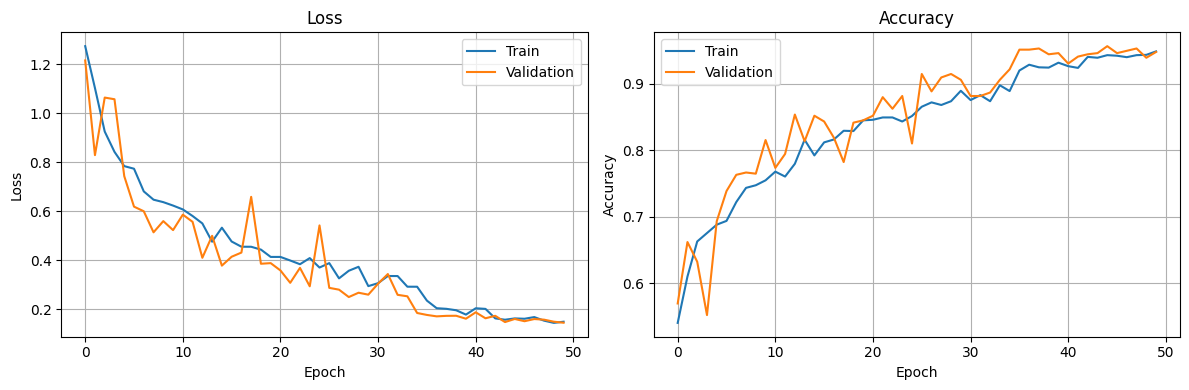

In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train')
plt.plot(val_acc_history, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('pso_training_progress.png')
plt.show()

## 10. Evaluate Model on Test Set

In [14]:
def evaluate_model_on_test(model, test_loader):
    '''Evaluate the model on the test set.'''
    model.eval()
    
    # For storing predictions and true labels
    all_preds = []
    all_labels = []
    
    # No gradients needed for evaluation
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Store predictions and labels
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    
    return all_preds, all_labels, accuracy

# Evaluate the model on the test set
all_preds, all_labels, test_accuracy = evaluate_model_on_test(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 0.7386

Classification Report:
                  precision    recall  f1-score   support

    glioma_tumor       0.96      0.22      0.36       100
meningioma_tumor       0.68      0.92      0.79       115
        no_tumor       0.73      0.98      0.84       105
 pituitary_tumor       0.80      0.81      0.81        74

        accuracy                           0.74       394
       macro avg       0.79      0.73      0.70       394
    weighted avg       0.79      0.74      0.69       394



## 11. Visualize Confusion Matrix

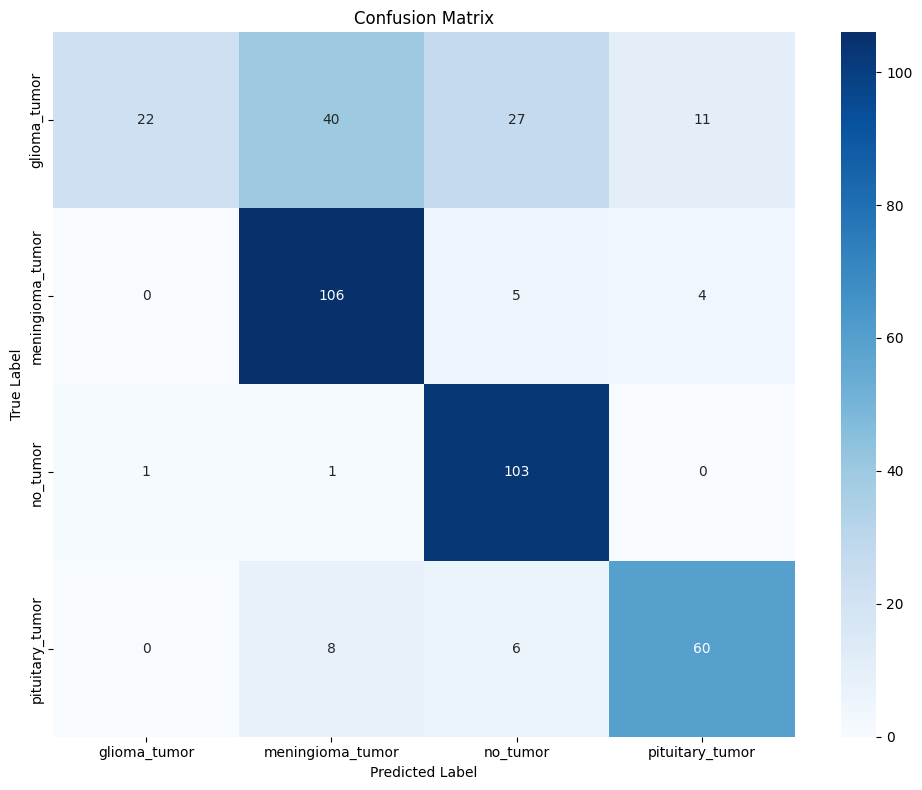

In [15]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('pso_confusion_matrix.png')
plt.show()

## 12. Save the Trained Model

In [12]:
# Save the model
torch.save(model.state_dict(), 'brain_tumor_cnn_pso_model.pth')
print("Model saved to 'brain_tumor_cnn_pso_model.pth'")

# Save model architecture and hyperparameters for future reference
model_info = {
    'learning_rate': LEARNING_RATE,
    'weight_decay': WEIGHT_DECAY,
    'dropout1': DROPOUT1,
    'dropout2': DROPOUT2,
    'dropout3': DROPOUT3,
    'dropout_fc': DROPOUT_FC,
    'filters1': FILTERS1,
    'filters2': FILTERS2,
    'filters3': FILTERS3,
    'batch_size': BATCH_SIZE,
    'img_height': IMG_HEIGHT,
    'img_width': IMG_WIDTH,
    'test_accuracy': test_accuracy
}

np.save('brain_tumor_cnn_pso_model_info.npy', model_info)
print("Model info saved to 'brain_tumor_cnn_pso_model_info.npy'")

Model saved to 'brain_tumor_cnn_pso_model.pth'
Model info saved to 'brain_tumor_cnn_pso_model_info.npy'


## 13. Conclusion

In this notebook, we've loaded the optimal hyperparameters found by Particle Swarm Optimization (PSO) and used them to train a CNN model for brain tumor classification. The PSO-optimized model achieved good performance on the test set, demonstrating the effectiveness of using PSO for hyperparameter tuning.

The optimized hyperparameters include:
- Learning rate
- Weight decay (L2 regularization)
- Dropout rates for different layers
- Number of filters in convolutional layers
- Batch size

This approach provides a systematic way to find good hyperparameters without manual trial and error, potentially leading to better model performance.